In [216]:
%matplotlib inline
# Common Imports
import numpy as np
#Pandas for creating dataframes
import pandas as pd
#Sklearn
from sklearn import preprocessing
#K-means clustering algo
from sklearn.cluster import KMeans
#OS moduled for file oprations
import os
#CSV module
import csv
#Plotting
import matplotlib.pyplot as plt

In [217]:
from scipy.spatial.distance import euclidean
def k_mean_dist(data, clusters, cluster_centers):
    distances = []
    for i, d in enumerate(data):
        center = cluster_centers[clusters[i]]
        distance = euclidean(d,center)
        #distance = np.linalg.norm(d - center)
        distances.append(distance)
    return distances

In [218]:
#Folder Base Path
base_path = 'converted/test2/'

In [220]:
#Cluster Path
#Normal
sample_path = base_path+'samples/'
cluster_path = base_path+'ip_cluster/'
#Attack
# sample_path = base_path+'attack_samples/1/'
# cluster_path = base_path+'attack_ip_cluster/1/'

centroid_path = base_path+'centroids/'

In [224]:
first = True
ip_dict = dict()
sample_count = 1;
columns = ['0','1','2','3']
centroid_dfs = []
first = True

for filename in os.listdir(sample_path):
    tdf = pd.read_csv(sample_path+filename, index_col=0)
    #Filter Columns
    t = tdf[['ip.dst', 'ip.proto', 'sniff_timestamp', 'sample']]
    #Remove null destinations
    t = t[t['ip.dst'].notnull()]
    #Rename Columns
    t.columns = ['ip', 'proto', 'time_stamp', 'sample']
    #Get count for each ip
    df = t.groupby(['ip', 'proto']).size().unstack().fillna(0).astype(int)
    #Select TCP and UDP as only fetures (TCP:6, UDP:17)
    df = df[[6,17]]
    #Get value matrix
    X = df.values
    #Create scaling
    scaler = preprocessing.StandardScaler().fit(X)
    #Transform Traning data
    X_trans = scaler.transform(X)
    #print(X_trans)
    #Define Number of Clusters
    cluster_count = 6
    #Data Fitting using K-means
    #if first:
    kmeans = KMeans(n_clusters=cluster_count)
    kmeans.fit(X_trans)
    #Insert cluster center to its corrosposnding dataframe each dataframe.
    #Dataframe 0 contain all the clusters centers associated with 0th cluster 
    for i in range(kmeans.cluster_centers_.shape[0]):
        s = pd.Series(kmeans.cluster_centers_[i], index=df.columns)
        if(first):
            centroid_dfs.append(pd.DataFrame(columns=df.columns))
        centroid_dfs[i] = centroid_dfs[i].append(s,ignore_index=True)         
    first = False

C:\Users\Tuli\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [225]:
#Calculate Centroid Mean
centroids = []
features = set()
for df in centroid_dfs:
    centroid = []
    for c in df.columns:
        df = df[np.abs(df[c] - df[c].mean()) <= (3*df[c].std())]
        #print(df[c])
        centroid.append(df[c].mean())
    centroids.append(centroid)
    features |= set(df.columns)
#Save centroid for future clusterinng
np.savetxt(centroid_path+"centroids.csv", np.asarray(centroids), delimiter=",")
np.savetxt(centroid_path+"features.csv", np.asarray(list(features)), delimiter=",")

C:\Users\Tuli\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Tuli\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:896: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


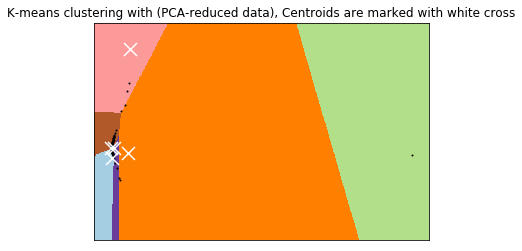

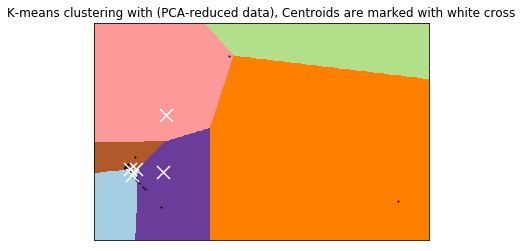

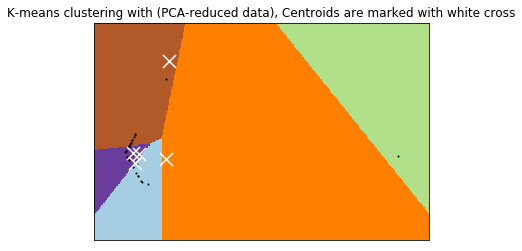

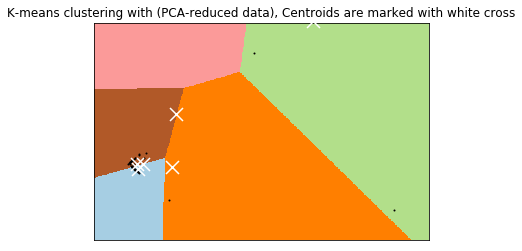

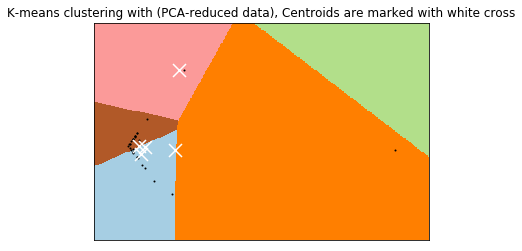

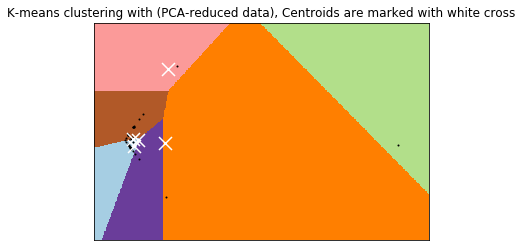

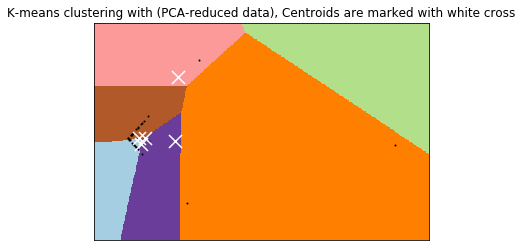

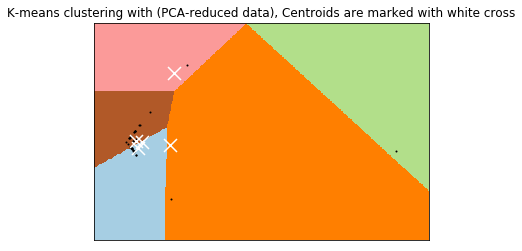

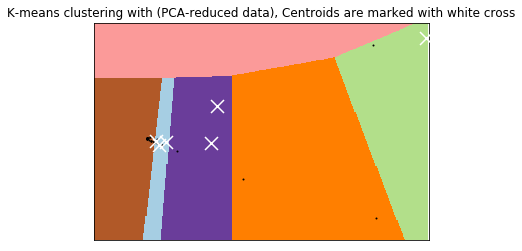

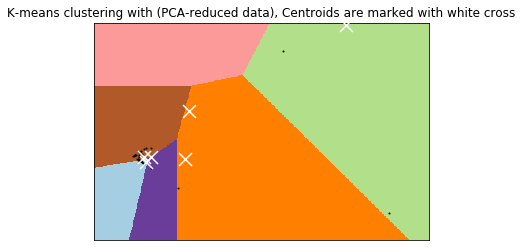

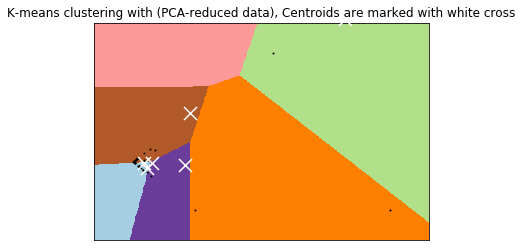

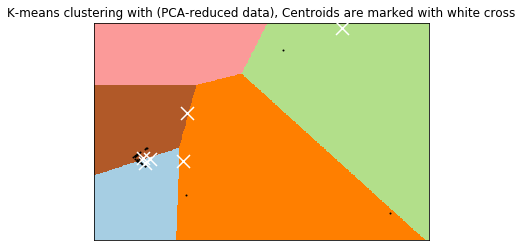

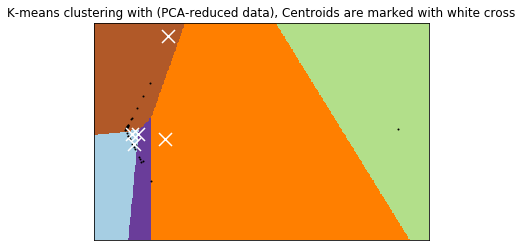

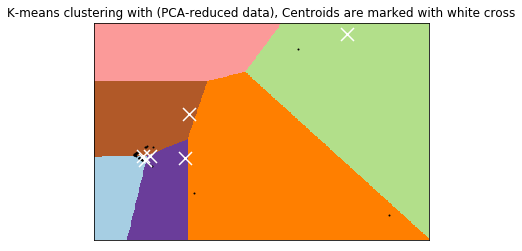

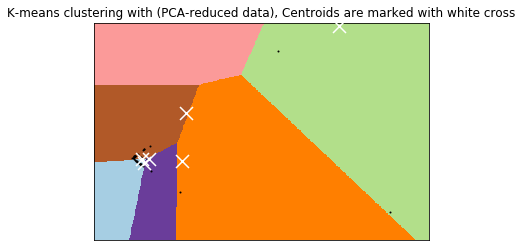

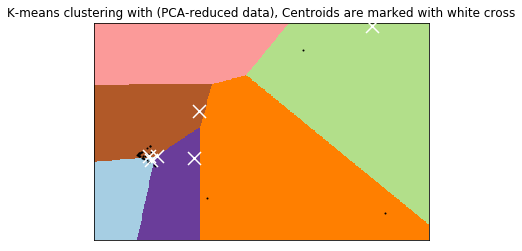

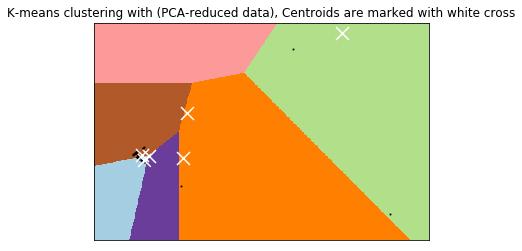

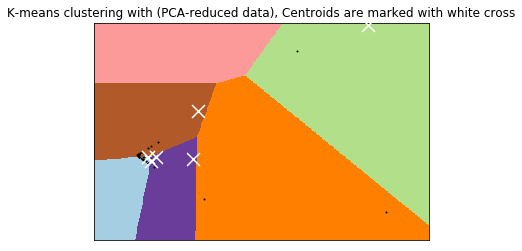

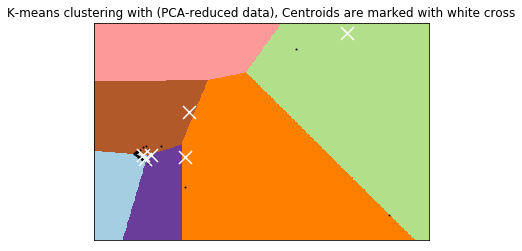

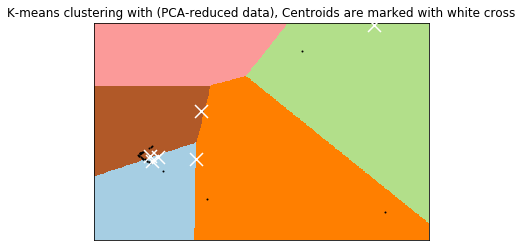

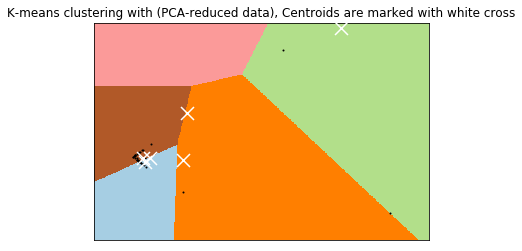

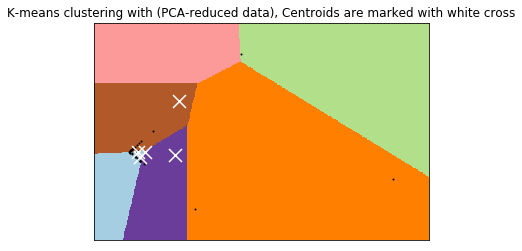

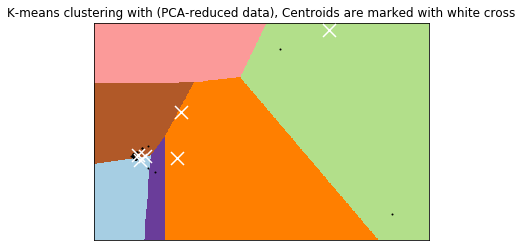

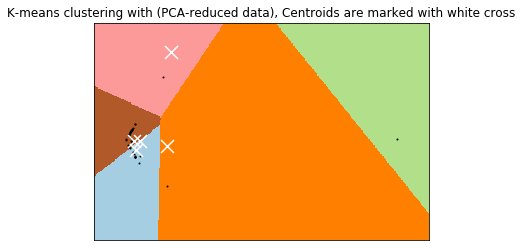

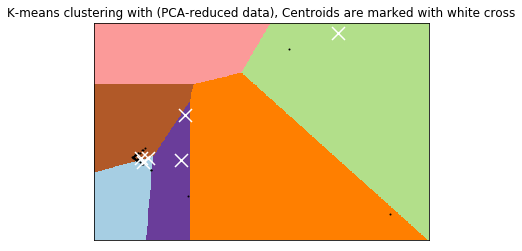

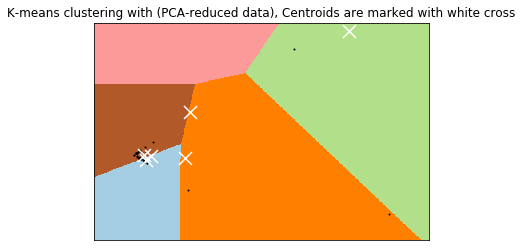

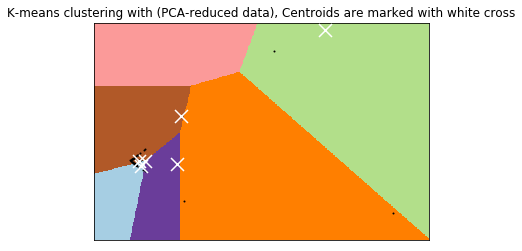

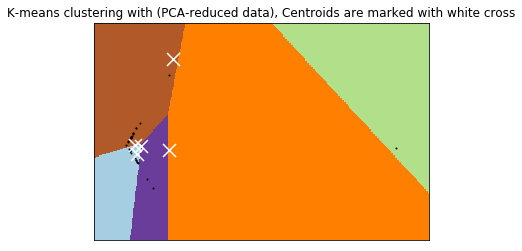

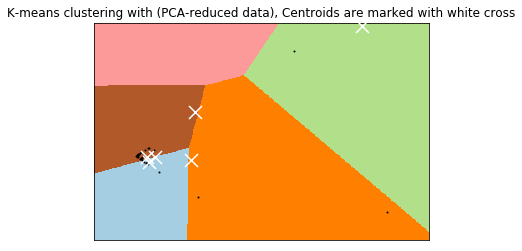

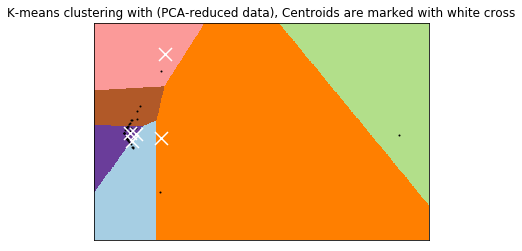

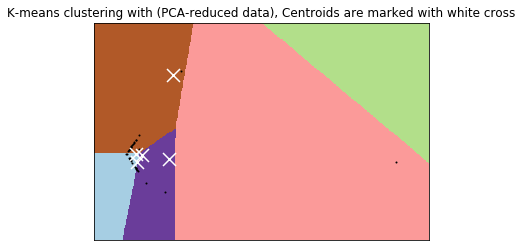

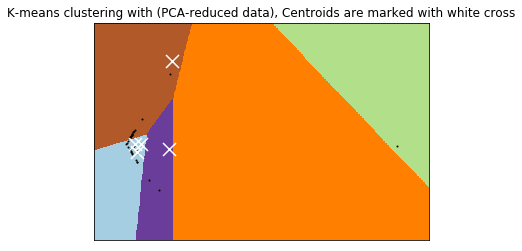

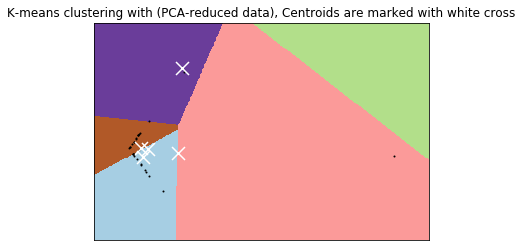

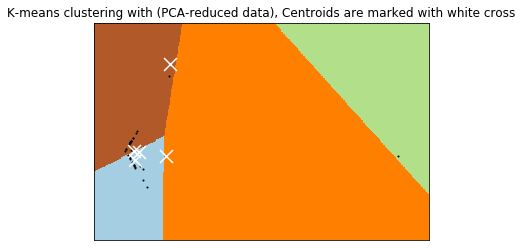

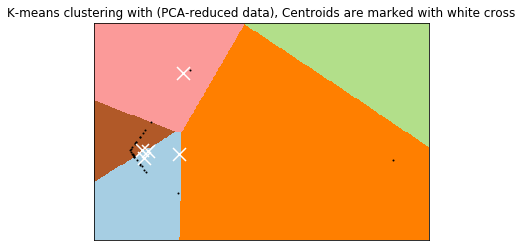

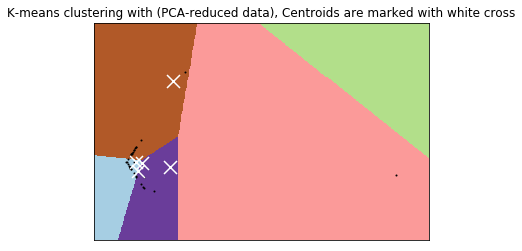

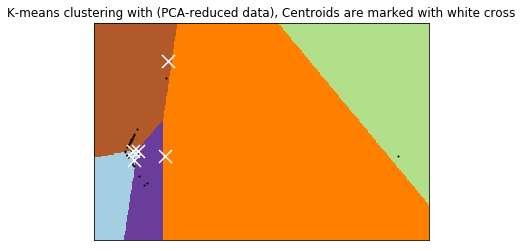

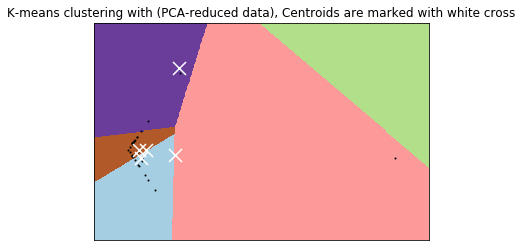

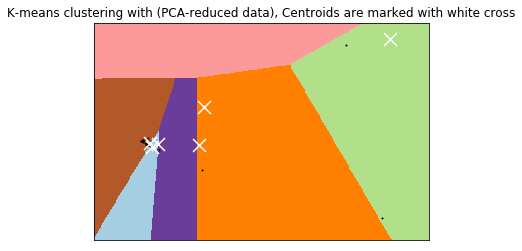

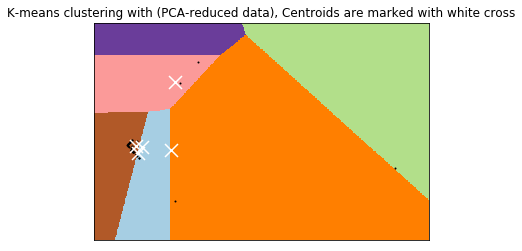

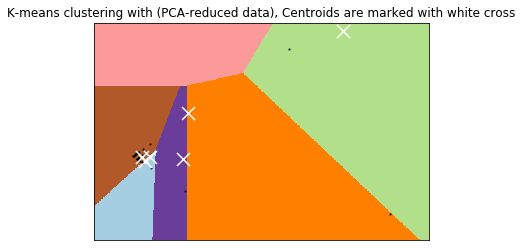

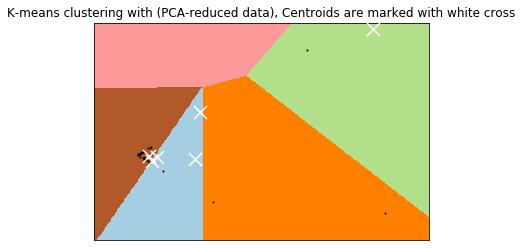

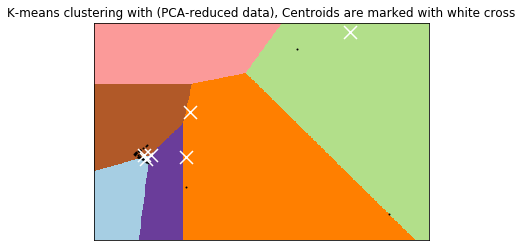

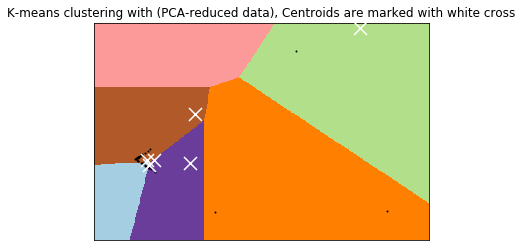

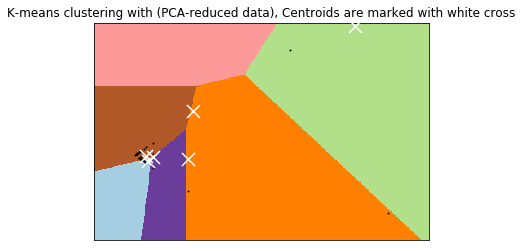

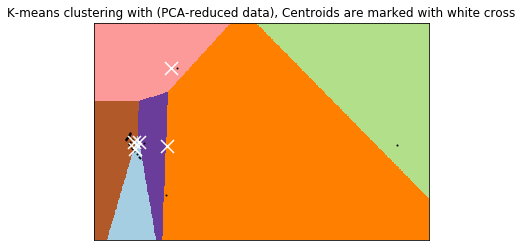

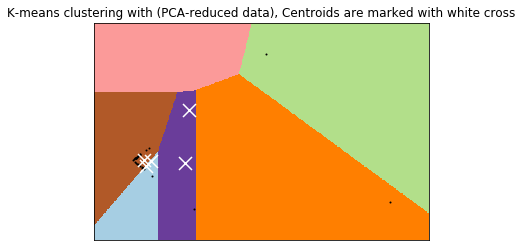

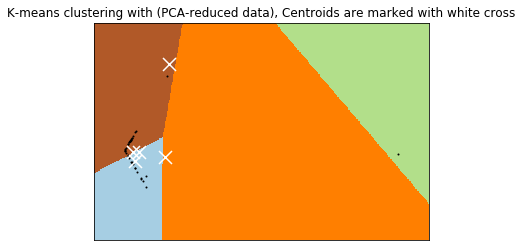

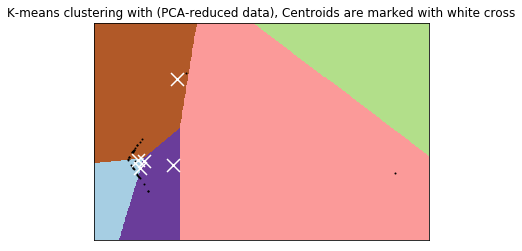

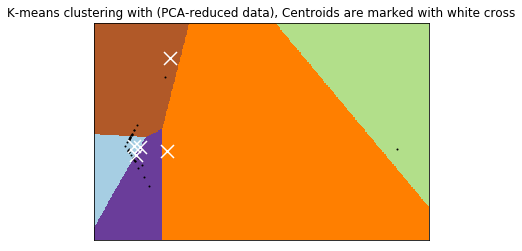

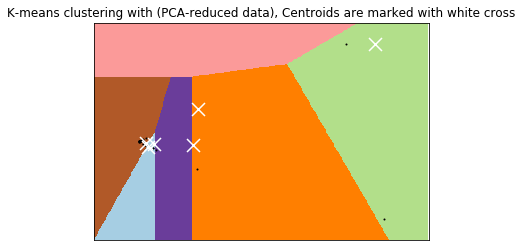

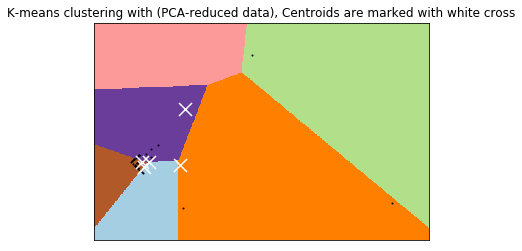

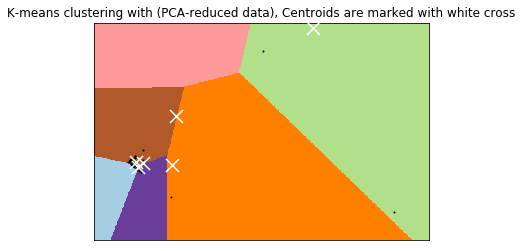

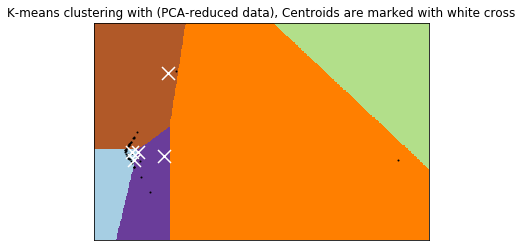

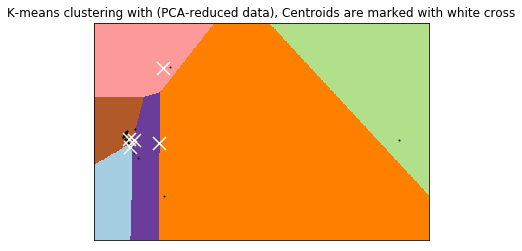

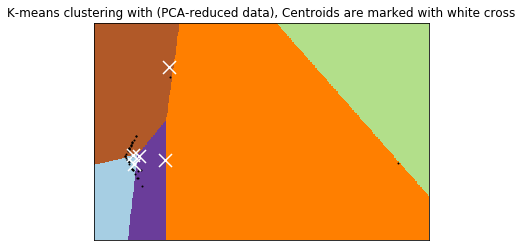

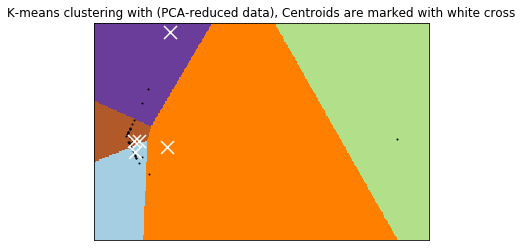

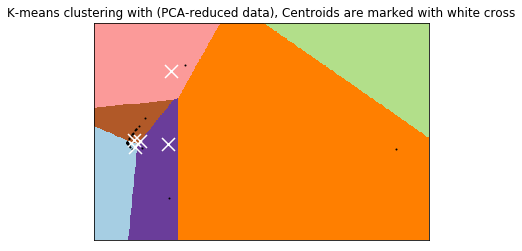

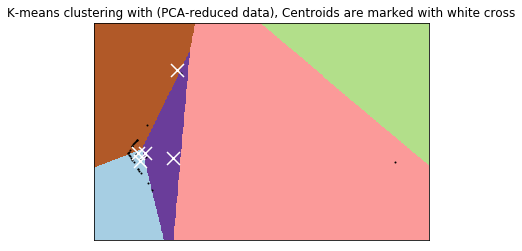

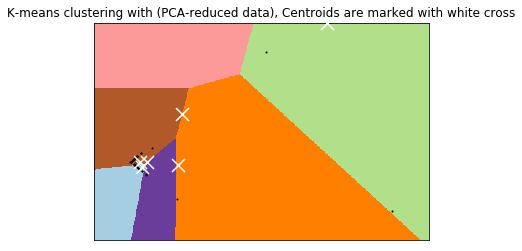

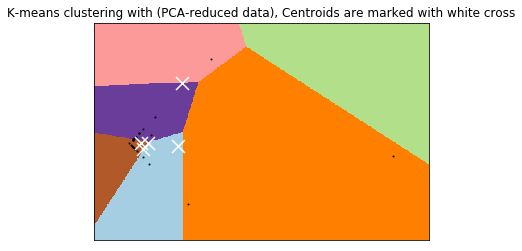

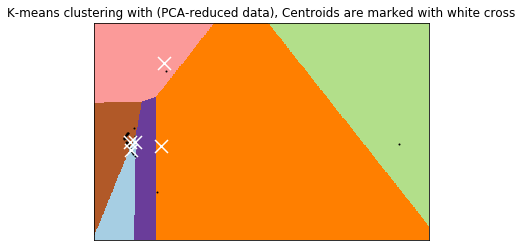

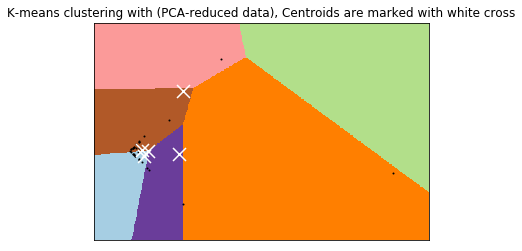

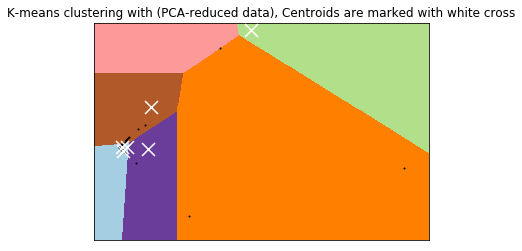

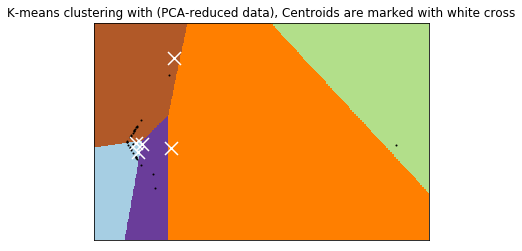

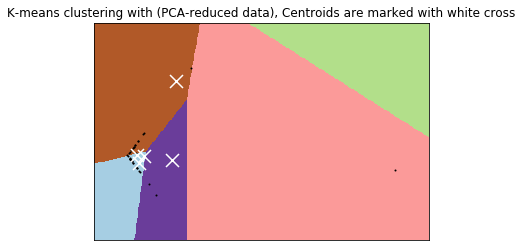

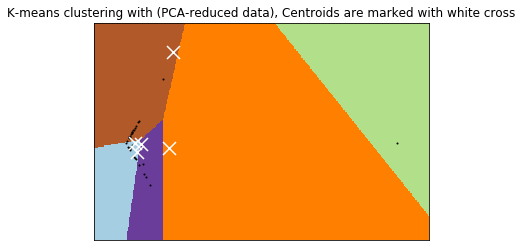

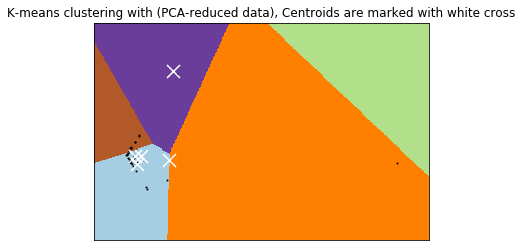

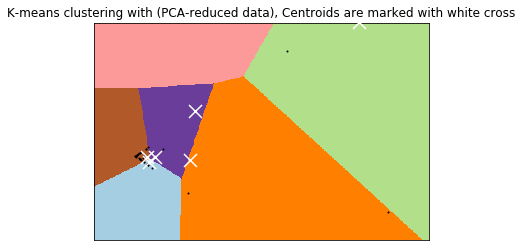

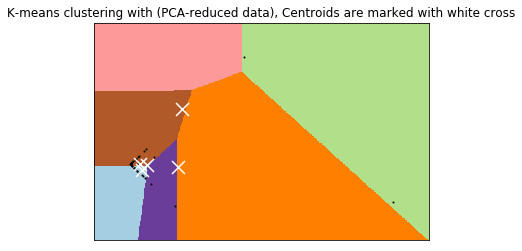

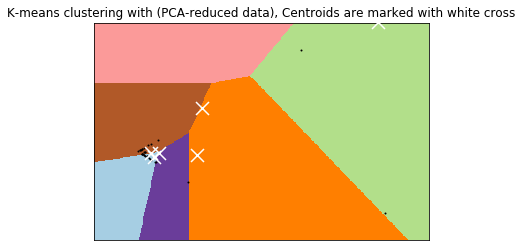

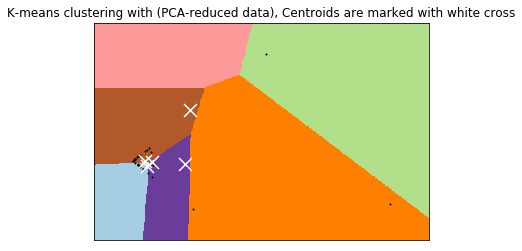

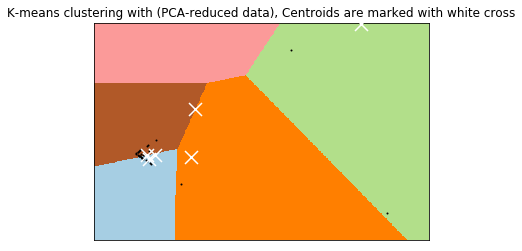

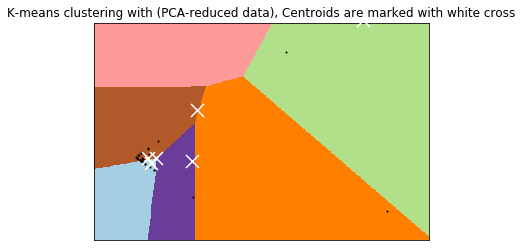

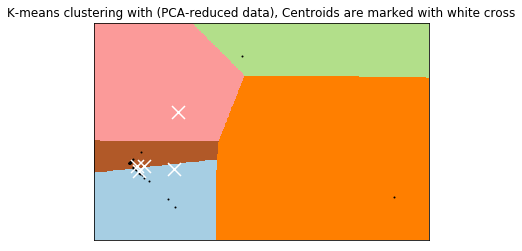

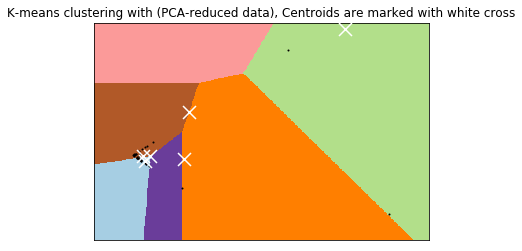

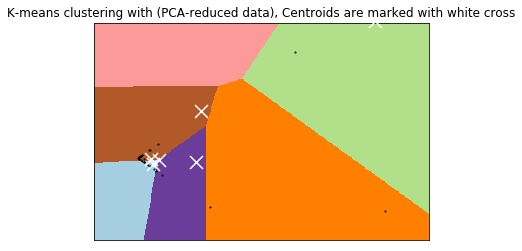

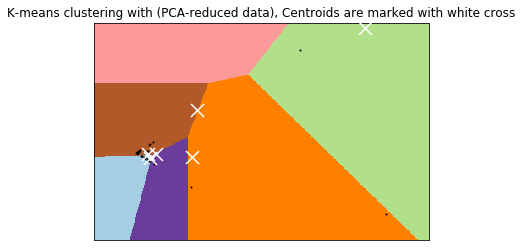

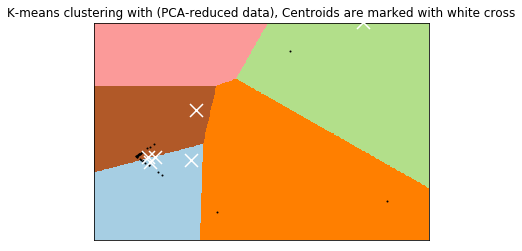

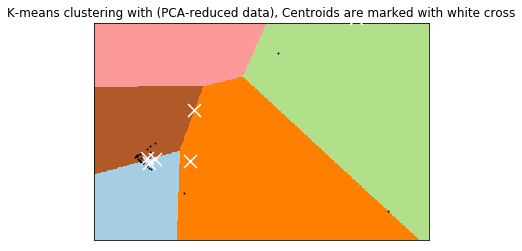

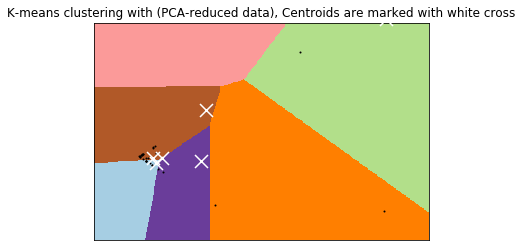

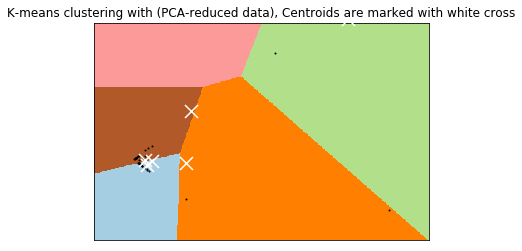

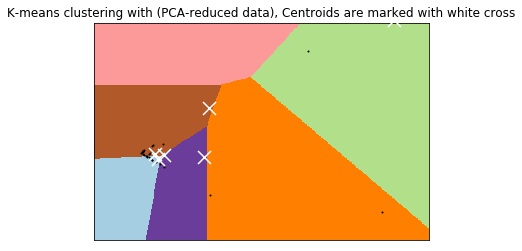

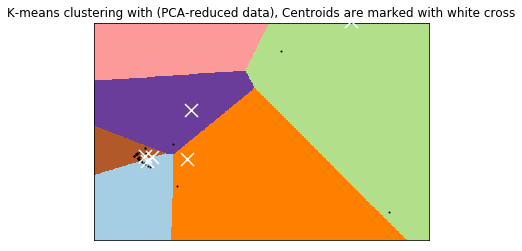

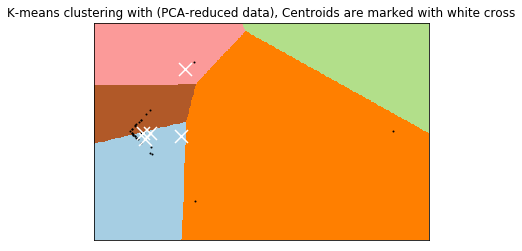

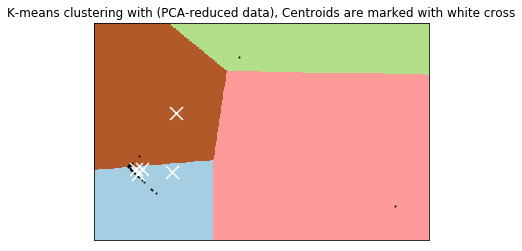

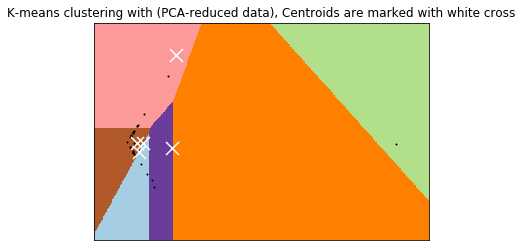

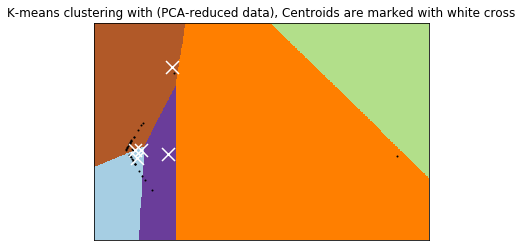

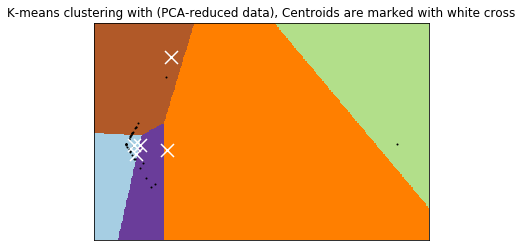

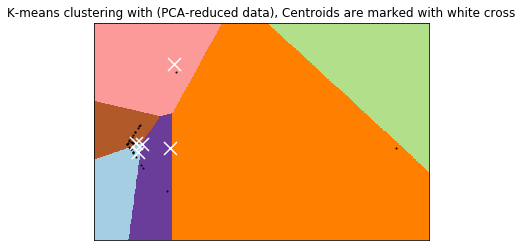

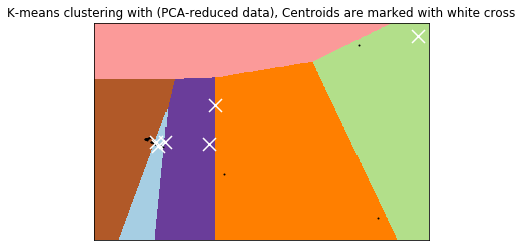

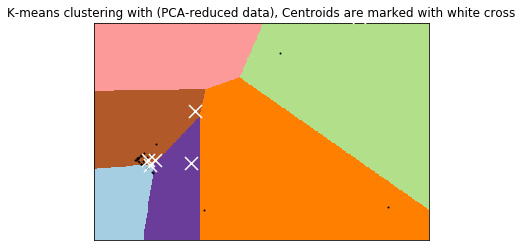

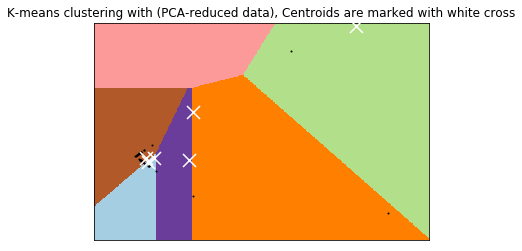

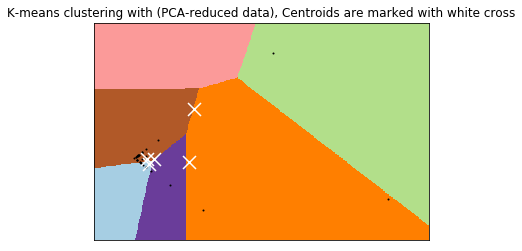

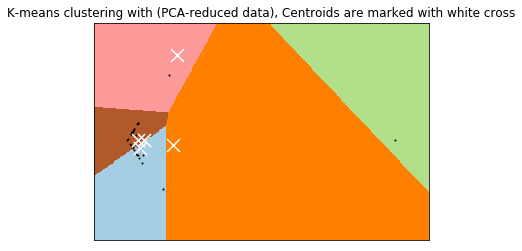

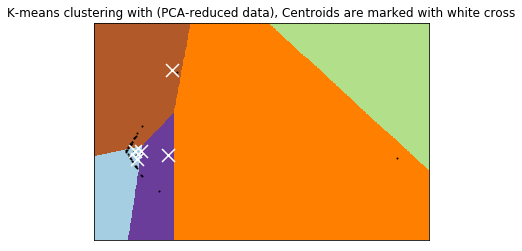

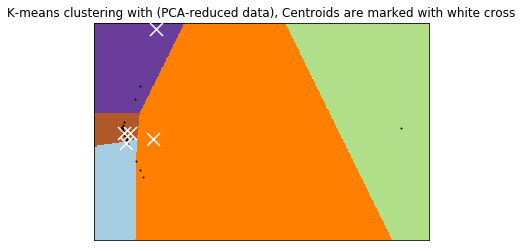

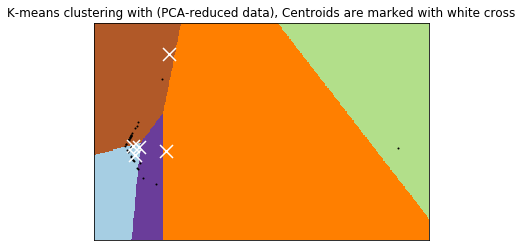

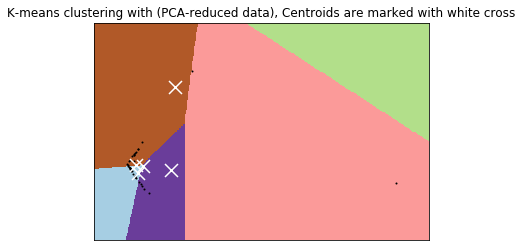

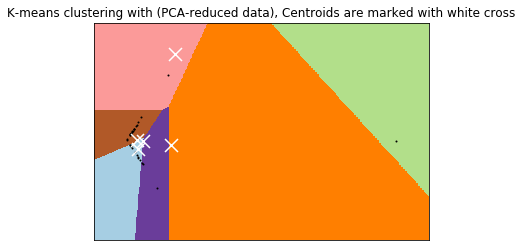

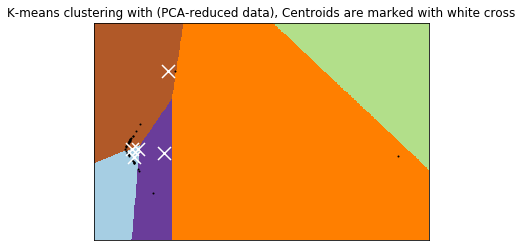

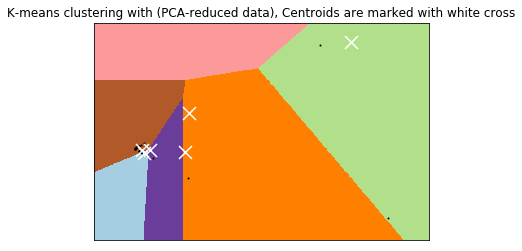

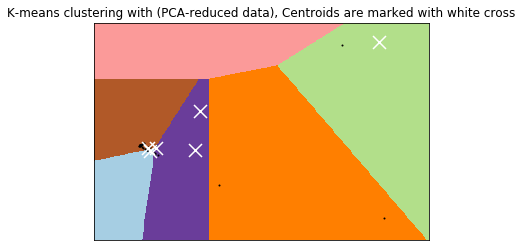

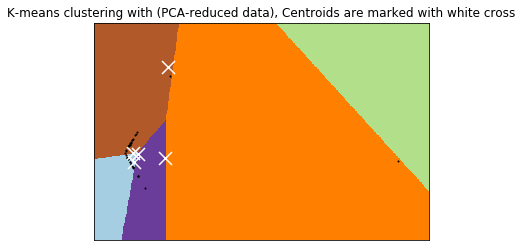

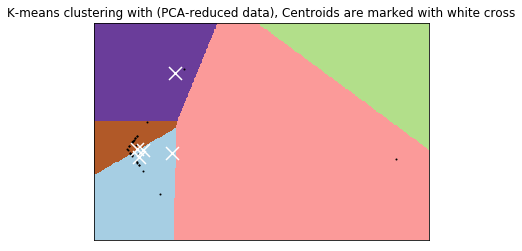

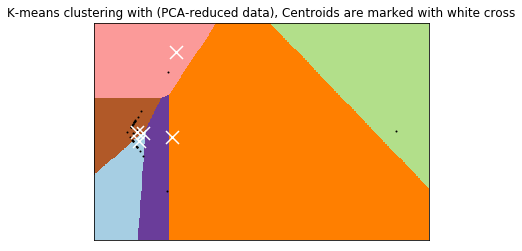

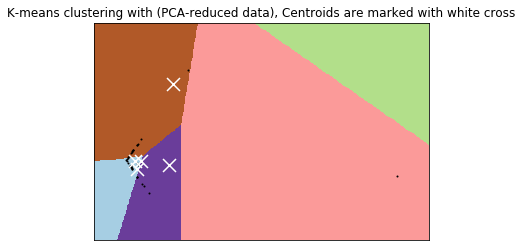

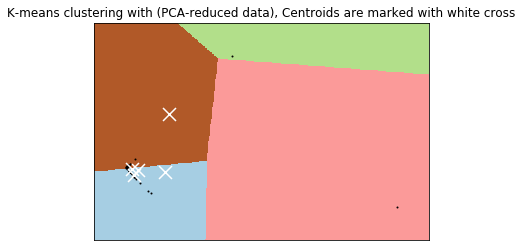

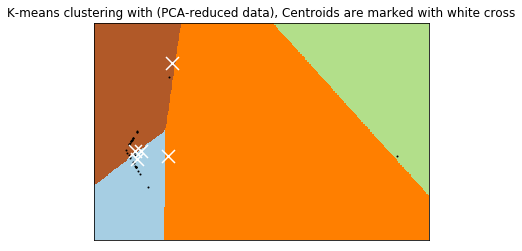

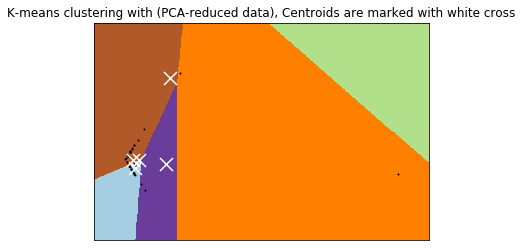

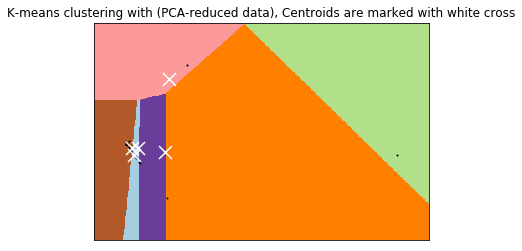

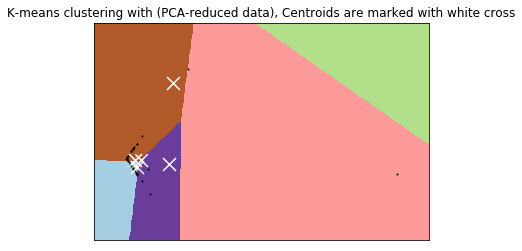

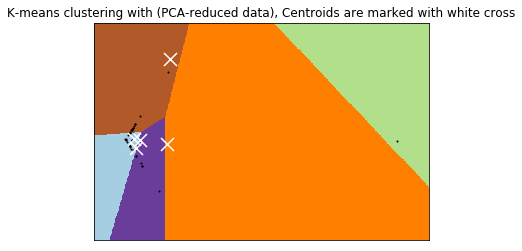

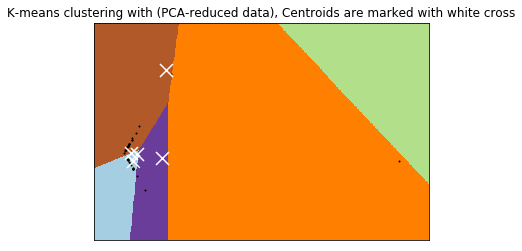

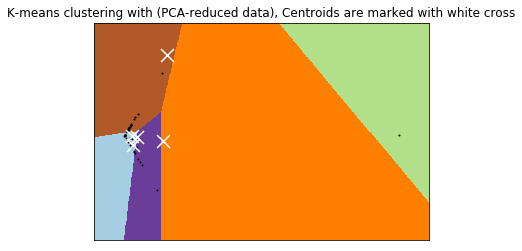

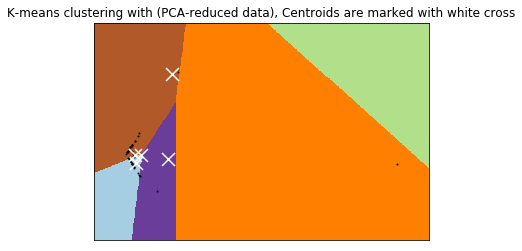

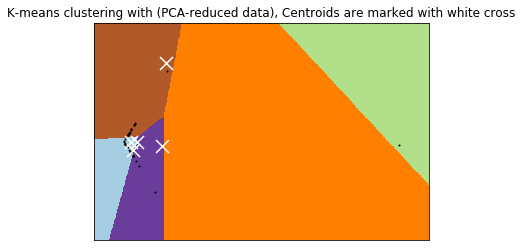

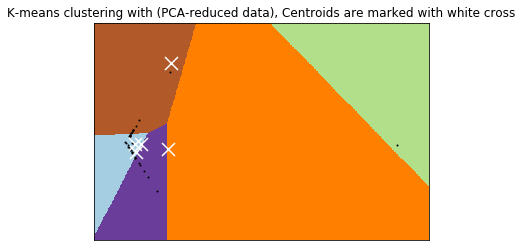

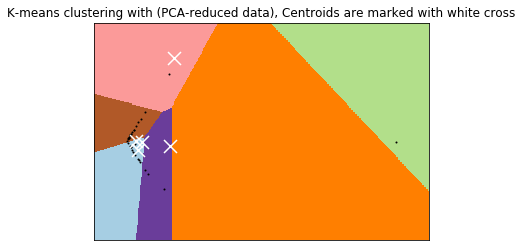

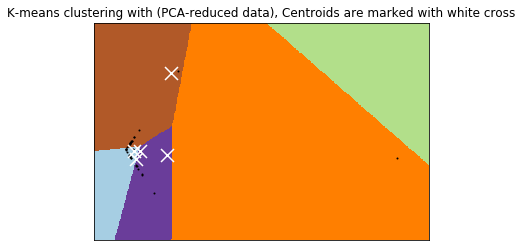

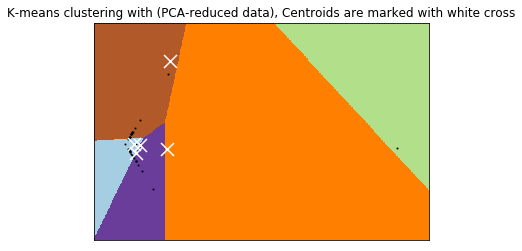

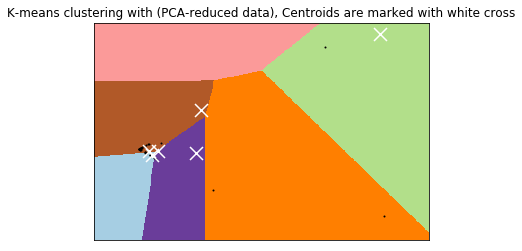

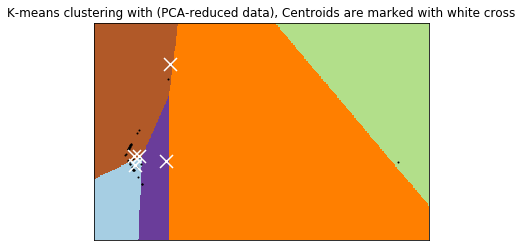

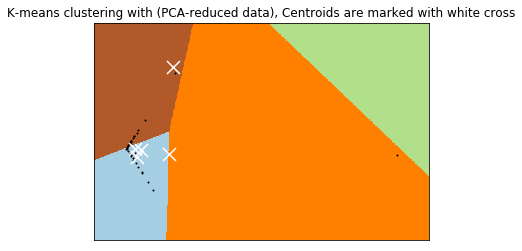

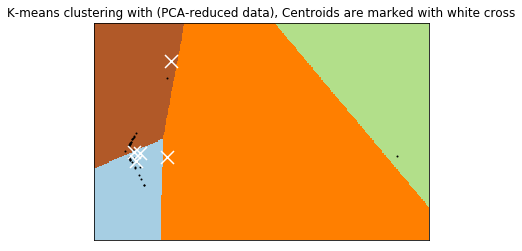

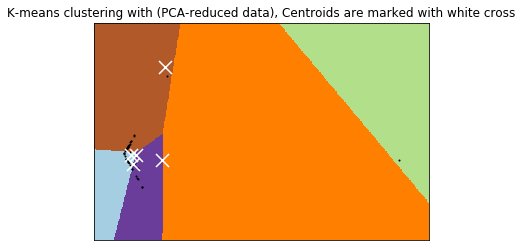

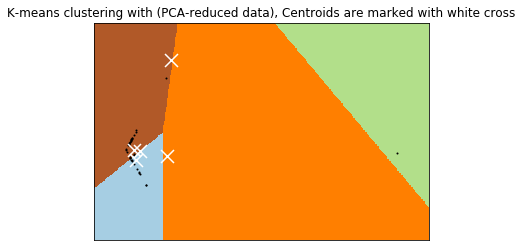

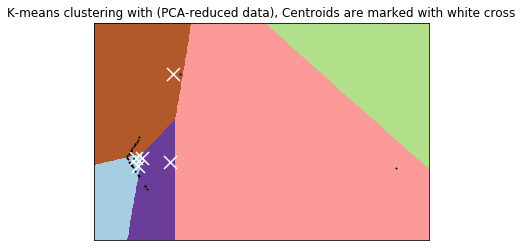

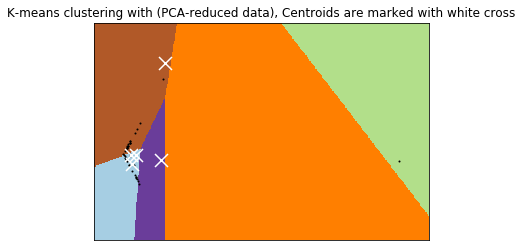

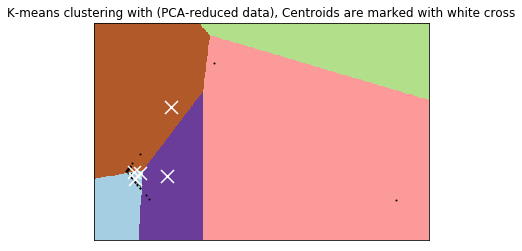

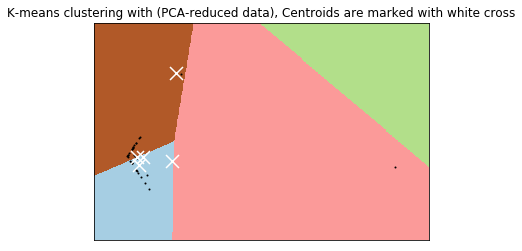

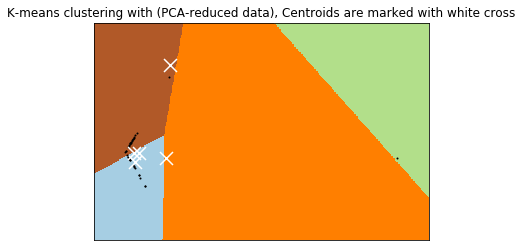

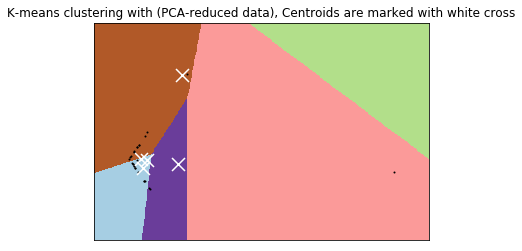

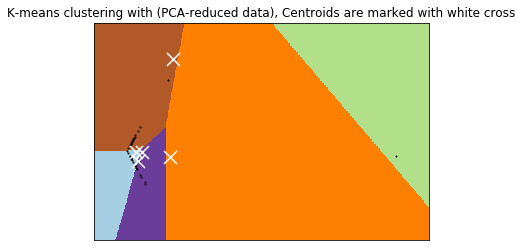

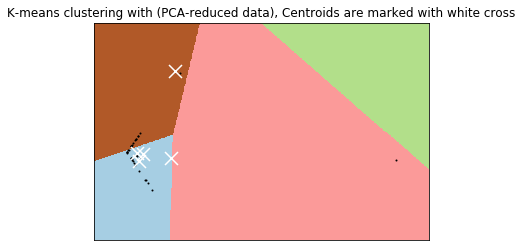

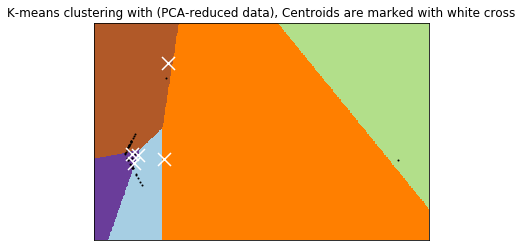

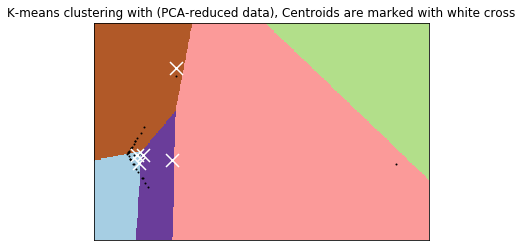

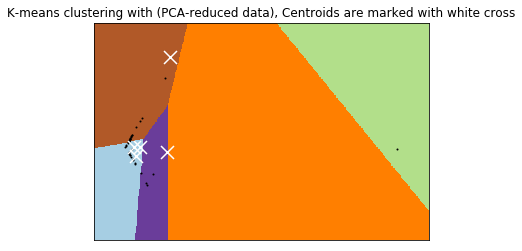

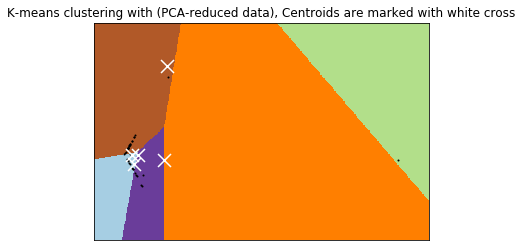

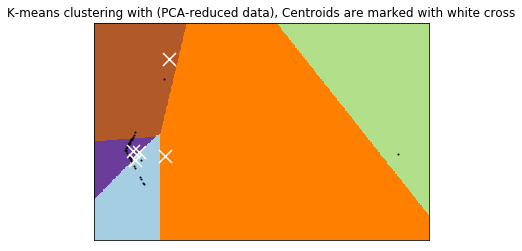

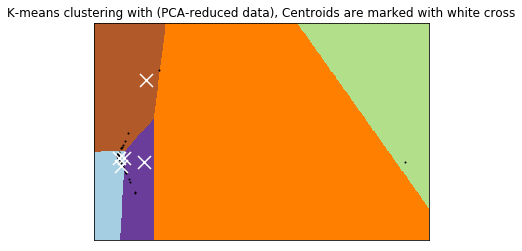

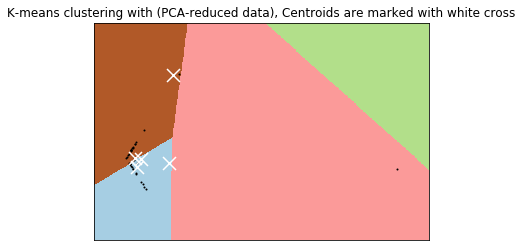

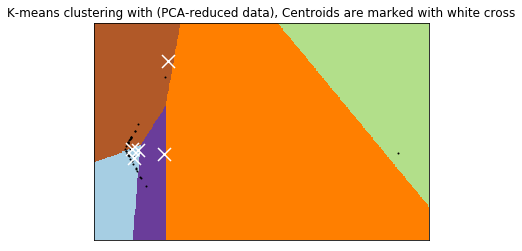

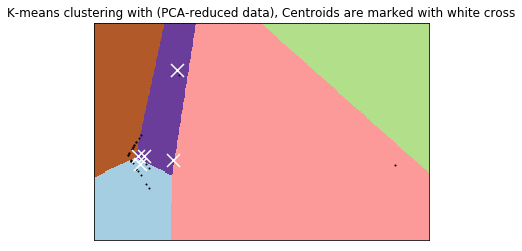

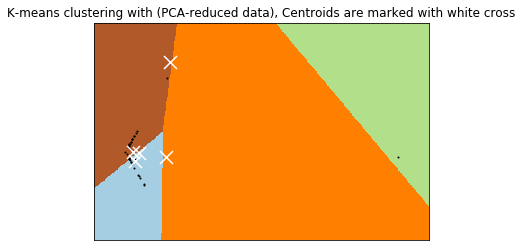

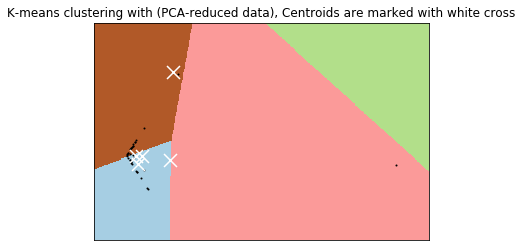

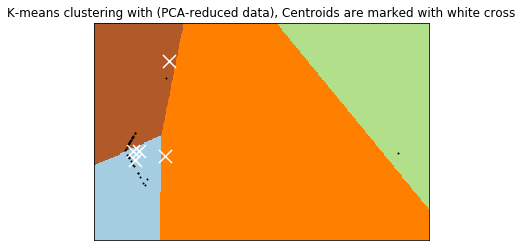

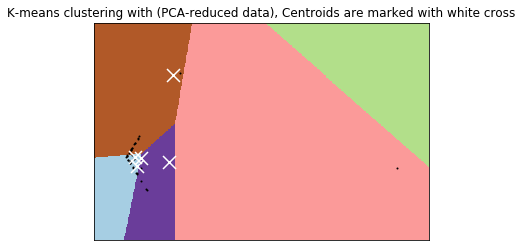

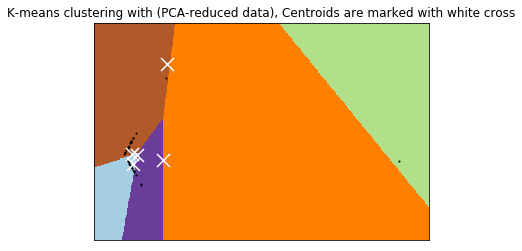

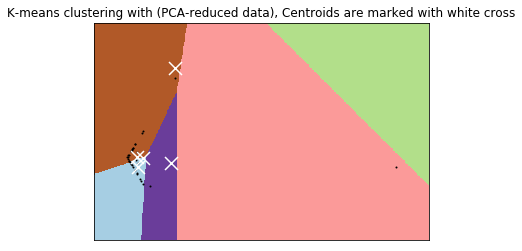

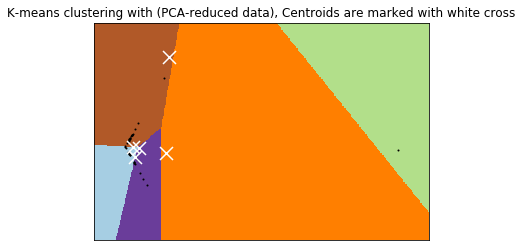

In [228]:
#Actual Clustering

#Get centroid created in initial step
centroids = np.genfromtxt(centroid_path+"centroids.csv", delimiter=',')
features = np.genfromtxt(centroid_path+"features.csv", delimiter=',')
sample_count = 1
for filename in os.listdir(sample_path):
    tdf = pd.read_csv(sample_path+filename, index_col=0)
    #Filter Columns
    t = tdf[['ip.dst', 'ip.proto', 'sniff_timestamp', 'sample']]
    #Remove null destinations
    t = t[t['ip.dst'].notnull()]
    #Rename Columns
    t.columns = ['ip', 'proto', 'time_stamp', 'sample']
    #Get count for each ip
    df = t.groupby(['ip', 'proto']).size().unstack().fillna(0).astype(int)
    #Select TCP and UDP as only fetures (TCP:6, UDP:17)
    df = df[[6,17]]
    if(set(df.columns) != set(features)):
        print(df.columns, features)
        non_columns = set(features) - set(df.columns)
        for c in non_columns:
            df.insert(loc=1, column=c, value=0)
    #Get value matrix
    X = df.values
    #Create scaling
    scaler = preprocessing.StandardScaler().fit(X)
    #Transform Traning data
    X_trans = scaler.transform(X)
    #Data Fitting using K-means
    kmeans = KMeans(n_clusters=centroids.shape[0], init=centroids)
    clusters = kmeans.fit_predict(X_trans)
    plot_clusters(X_trans, clusters, centroids, kmeans)
    distances = k_mean_dist(X_trans, clusters, centroids)
    #Attaching label/cluster to IP
    cluster_df = pd.DataFrame({'cluster': kmeans.labels_})
    #Attaching distance from the cluster for each data point
    distance_df = pd.DataFrame({'distance': distances})
    ip_label_df = pd.concat([df.reset_index(), cluster_df, distance_df], axis=1).set_index('ip')
    if not os.path.exists(cluster_path):
        os.makedirs(cluster_path)
    ip_label_df.to_csv(cluster_path+str(sample_count))
    sample_count += 1

In [204]:
# Calculating Eigenvectors and eigenvalues of Cov matirx
def PCA_component_analysis(X_std):
    mean_vec = np.mean(X_std, axis=0)
    cov_mat = np.cov(X_std.T)
    eig_vals, eig_vecs = np.linalg.eig(cov_mat)

    # Create a list of (eigenvalue, eigenvector) tuples
    eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

    # # Sort from high to low
    eig_pairs.sort(key = lambda x: x[0], reverse= True)

    # Calculation of Explained Variance from the eigenvalues
    tot = sum(eig_vals)
    var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
    cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

    # PLOT OUT THE EXPLAINED VARIANCES SUPERIMPOSED 
    plt.figure(figsize=(10, 5))
    plt.bar(range(9), var_exp, alpha=0.3333, align='center', label='individual explained variance', color = 'g')
    plt.step(range(9), cum_var_exp, where='mid',label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.show()

In [227]:
from sklearn.decomposition import PCA
def plot_clusters(X, X_clusters, centroids, kmeans):
    #Use PCA component analysis for visuals
    reduced_X = PCA(n_components=2).fit_transform(X)
   
    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_X[:, 0].min() - 1, reduced_X[:, 0].max() + 1
    y_min, y_max = reduced_X[:, 1].min() - 1, reduced_X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')   
    #Plot the data points (PCA reduced components)
    plt.plot(reduced_X[:,0],reduced_X[:,1],  'k.', markersize=2) 
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=169, linewidths=3, color='w', zorder=10)
    plt.title('K-means clustering with (PCA-reduced data), Centroids are marked with white cross')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

In [199]:
from itertools import groupby
ip_dict = dict()

for filename in os.listdir(cluster_path):
    with open(cluster_path+filename, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if row['ip'] in ip_dict:
                #print(row['ip'],ip_dict[row['ip']])
                ip_dict[row['ip']] = ip_dict[row['ip']] + [row['cluster']]
            else:
                ip_dict[row['ip']] = [row['cluster']]

In [200]:
ip_cluster_dict = dict()
#Find count of clusters 
for key, value in ip_dict.items():
    ip_cluster_dict[key] = {k: len(list(group)) for k, group in groupby(value)}

In [201]:
ip_cluster_dict

{'104.208.156.39': {'0': 1},
 '172.217.10.109': {'0': 1},
 '172.217.10.110': {'0': 1},
 '172.217.10.14': {'0': 1},
 '172.217.10.227': {'0': 1},
 '172.217.10.234': {'0': 1},
 '172.217.10.238': {'0': 1},
 '172.217.12.174': {'0': 1},
 '172.217.9.238': {'0': 1},
 '173.194.204.189': {'0': 1},
 '173.194.206.189': {'0': 1},
 '173.194.208.189': {'0': 1},
 '173.194.68.189': {'0': 1},
 '192.168.0.10': {'2': 1},
 '192.168.0.4': {'0': 1},
 '192.168.0.7': {'1': 1},
 '216.58.219.227': {'0': 1},
 '216.58.219.229': {'0': 1},
 '224.0.0.251': {'0': 1},
 '52.1.34.253': {'2': 1},
 '52.200.131.105': {'0': 1},
 '54.175.13.65': {'0': 1},
 '54.84.217.201': {'0': 1},
 '65.19.96.252': {'0': 1},
 '65.19.96.253': {'0': 1},
 '65.52.108.76': {'0': 1}}

In [ ]:
#Group IP by clusters and write to file
for filename in os.listdir(cluster_path):
    df = pd.read_csv(cluster_path+filename, index_col=0)
    
    if not os.path.exists(base_directory):
                    os.makedirs(base_directory)


In [157]:
df = pd.DataFrame([np.arange(5)]*3)

In [161]:
df[0] = df[0]+1

In [162]:
df

,0,1,2,3,4
0,1,1,2,3,4
1,1,1,2,3,4
2,1,1,2,3,4


In [153]:
[np.arange(10)]*3

[array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])]